In [ ]:
# Standard IPython notebook imports
%matplotlib inline

import os
from io import StringIO

import graphviz
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import pandas as pd
import scipy.stats as sstats
import seaborn as sns
import sklearn.ensemble
import sklearn.tree
from sklearn.linear_model import LinearRegression
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score
sns.set_style("whitegrid")

At the beginning we import 4 datasets and put them in different dataframes, with data types converted to int32 and one float.
We also print head of each dataframe with target distribution just to see what we have to work with.

In [ ]:
# Data
import csv
import io
import urllib.request

# Data urls
urls = { 
    'cleveland': 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data',
    'switzerland': 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data',
    'va': 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data',
    'hungarian': 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data',
}

# Data headers, types
data_types ={
    'Age':'int32',
    'Sex':'int32',
    'Cp':'int32',
    'Trestbps':'int32',
    'Chol':'int32',
    'Fbs':'int32',
    'Restecg':'int32',
    'Thalach':'int32',
    'Exang':'int32',
    'Oldpeak':'float',
    'Slope':'int32',
    'Ca':'int32',
    'Thal':'int32',
    'Target':'int32',
}


# Download data
data = {}
for key,url in urls.items():
    with urllib.request.urlopen(url) as response:
        data[key] = io.StringIO(response.read().decode('UTF-8'))

# Import data into dataframes
dataframes = {}
for key,data in data.items():
    # Replace ? with -1 in data
    dataframes[key] = pd.read_csv(data, names=data_types.keys()).replace("?", -1)

    # Convert to specified types
    dataframes[key] = dataframes[key].astype(float).astype(data_types)

    # Map target to True/False
    dataframes[key]['Target'] = dataframes[key]['Target'].map(lambda t: t != 0)

    print("\n\n", key)
    print(dataframes[key].head())
    print(dataframes[key][dataframes[key].Target == True].shape[0]/dataframes[key].shape[0] * 100, "% True", sep='')
    print(dataframes[key][dataframes[key].Target == False].shape[0]/dataframes[key].shape[0] * 100, "% False", sep='')




 cleveland
   Age  Sex  Cp  Trestbps  Chol  Fbs  ...  Exang  Oldpeak  Slope  Ca  Thal  Target
0   63    1   1       145   233    1  ...      0      2.3      3   0     6   False
1   67    1   4       160   286    0  ...      1      1.5      2   3     3    True
2   67    1   4       120   229    0  ...      1      2.6      2   2     7    True
3   37    1   3       130   250    0  ...      0      3.5      3   0     3   False
4   41    0   2       130   204    0  ...      0      1.4      1   0     3   False

[5 rows x 14 columns]
45.87458745874587% True
54.12541254125413% False


 switzerland
   Age  Sex  Cp  Trestbps  Chol  Fbs  ...  Exang  Oldpeak  Slope  Ca  Thal  Target
0   32    1   1        95     0   -1  ...      0      0.7      1  -1    -1    True
1   34    1   4       115     0   -1  ...      0      0.2      1  -1    -1    True
2   35    1   4        -1     0   -1  ...      1     -1.0     -1  -1     7    True
3   36    1   4       110     0   -1  ...      1      1.0      2  -1  

Right off the bat we can see that the target distributions are far from desirable, therefore we decided to use stratified k-fold to split each dataset.

The first method we try is KNN.

In [ ]:
def KNN(X, Y, df, ks):
    
    nSplits = 8
    results = []
    bestKNN = (None, 0)

    for k in ks:
        kf = StratifiedKFold(n_splits=nSplits, random_state=None, shuffle=False)
        acc_preds = []
        f1_preds = []
        rec_preds = []
        for train_index, test_index in kf.split(df, Y):
          
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

            neigh = KNeighborsClassifier(n_neighbors=k)
            neigh.fit(X_train, y_train)
            acc_preds.append(accuracy_score(y_test, neigh.predict(X_test)))
            f1_preds.append(f1_score(y_test, neigh.predict(X_test)))
            rec_preds.append(recall_score(y_test, neigh.predict(X_test)))
        
        acc = np.sum(acc_preds)/nSplits
        f1 = np.sum(f1_preds)/nSplits
        rec = np.sum(rec_preds)/nSplits

        if acc > bestKNN[1]:
            bestKNN = (deepcopy(neigh), acc)

        results.append({'K' : k, 
                        'Acc': acc,
                        'F-1': f1,
                        'Rec': rec
                        })

    # results_df will be a data_frame in long format
    results_df = pd.DataFrame(results)

    return results_df, bestKNN[0]

<Figure size 432x288 with 0 Axes>

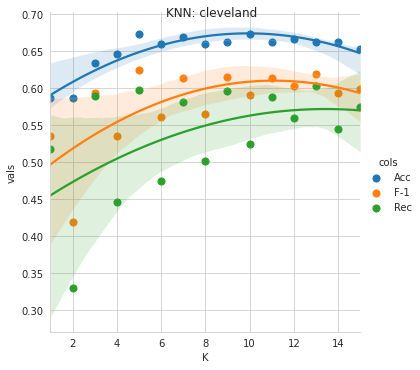

<Figure size 432x288 with 0 Axes>

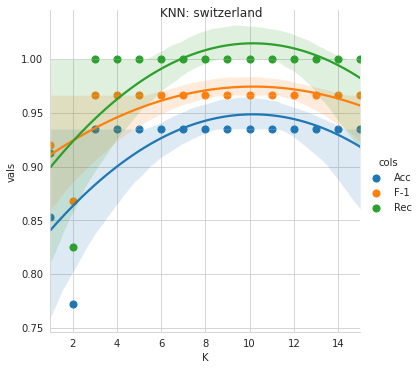

<Figure size 432x288 with 0 Axes>

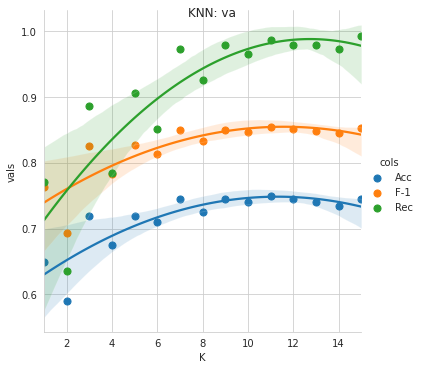

<Figure size 432x288 with 0 Axes>

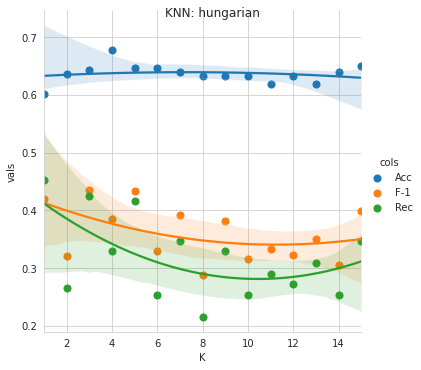

In [ ]:
for source in dataframes:
    knn_X = dataframes[source].drop('Target', axis=1)
    results_df = KNN(knn_X, dataframes[source]['Target'], dataframes[source], range(1, 16))[0]

    df_melt = results_df.melt('K', var_name='cols', value_name='vals')

    plt.figure()
    sns.lmplot(x='K', y='vals', data=df_melt, x_estimator=np.mean, order=2, hue='cols')
    plt.gcf().suptitle("KNN: " + source)

Overall the results are already well above 50%, and in case of switzerland it's above 90%. That is most likel|y because target distribution in this dataset is about 93% to 6%, and it seems that even stratified k-fold doesn't help much in this case.

After that we give random forests a shot. The results are much better, with accuracy oscilating between 70% and 80%. For now we decided to ommit switzerland for mentioned reasons.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
def RF(X, Y, df, ks):

    nSplits = 5
    results = []
    bestFOR = (None, 0)

    for k in ks:
        kf = StratifiedKFold(n_splits=nSplits, random_state=None, shuffle=False)
        acc_preds = []
        f1_preds = []
        rec_preds = []
        for train_index, test_index in kf.split(df, Y):
            
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

            forests = RandomForestClassifier(max_depth=k, random_state=0)
            forests.fit(X_train, y_train)
        
            acc_preds.append(accuracy_score(y_test, forests.predict(X_test)))
            f1_preds.append(f1_score(y_test, forests.predict(X_test)))
            rec_preds.append(recall_score(y_test, forests.predict(X_test)))
      
        acc = np.sum(acc_preds)/nSplits
        f1 = np.sum(f1_preds)/nSplits
        rec = np.sum(rec_preds)/nSplits

        if acc > bestFOR[1]:
            bestFOR = (deepcopy(forests), acc)

        results.append({'MaxTreeDepth' : k,
                        'Acc': acc,
                        'F-1': f1,
                        'Rec': rec
                        })

    # results_df will be a data_frame in long format
    return pd.DataFrame(results), bestFOR[0]


/usr/local/lib/python3.6/dist-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.6/dist-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.6/dist-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))


<Figure size 432x288 with 0 Axes>

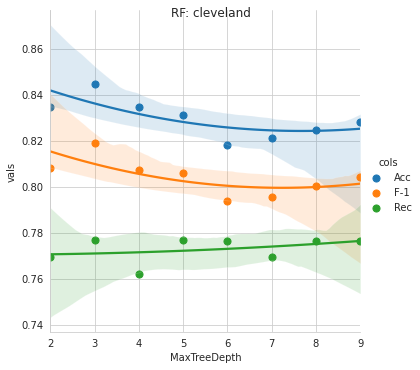

<Figure size 432x288 with 0 Axes>

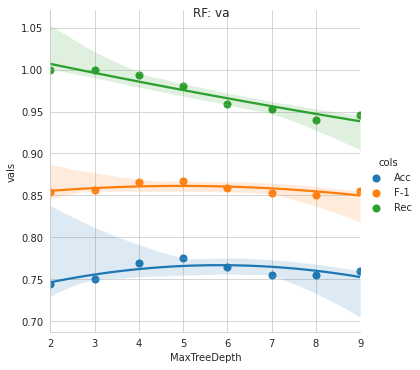

<Figure size 432x288 with 0 Axes>

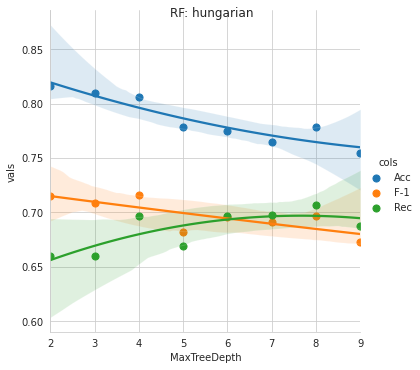

In [ ]:
sources = ['cleveland', 'va', 'hungarian']
for source in sources:
    rf_X = dataframes[source].drop('Target', axis=1)
    results_df = RF(rf_X, dataframes[source]['Target'], dataframes[source], range(2, 10))[0]

    df_melt = results_df.melt('MaxTreeDepth', var_name='cols', value_name='vals')

    plt.figure()
    sns.lmplot(x='MaxTreeDepth', y='vals', data=df_melt, x_estimator=np.mean, order=2, hue='cols')
    plt.gcf().suptitle("RF: " + source)

The next step was to merge the datasets into one. Additionaly we've added a column telling which dataset the sample comes from. To do that we used one hot encoding.

In [ ]:
dataframes['switzerland']['Target'].value_counts()

True     115
False      8
Name: Target, dtype: int64

In [ ]:
# One hot encoding for sources
sources_encoded = {}
for i, source in enumerate(dataframes.keys()):
  sources_encoded[source] = 1 << i

# Combine dataframes
for key, df in dataframes.items():
  df["source"] = sources_encoded[key]

combined_df = pd.concat(dataframes.values())
combined_df

,Age,Sex,Cp,Trestbps,Chol,Fbs,Restecg,Thalach,Exang,Oldpeak,Slope,Ca,Thal,Target,source
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,False,1
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,True,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,True,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,False,1
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,52,1,4,160,331,0,0,94,1,2.5,-1,-1,-1,True,8
290,54,0,3,130,294,0,1,100,1,0.0,2,-1,-1,True,8
291,56,1,4,155,342,1,0,150,1,3.0,2,-1,-1,True,8
292,58,0,2,180,393,0,0,110,1,1.0,2,-1,7,True,8


Then we proceeded to do the same tests for merged dataset, with and without the source column.

Text(0.5, 0.98, 'KNN: Combined df without source column')

<Figure size 432x288 with 0 Axes>

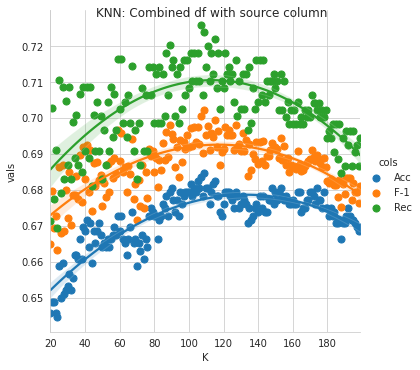

<Figure size 432x288 with 0 Axes>

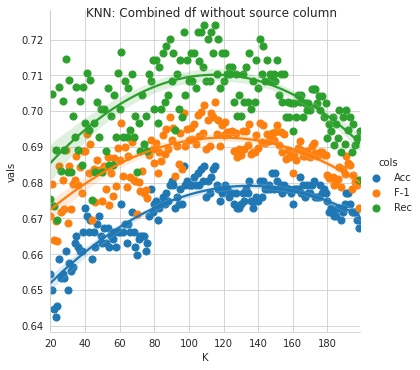

In [ ]:
# KNN with source column
knn_combined_X = combined_df.drop('Target', axis=1)
results_df, best_KNN = KNN(knn_combined_X, combined_df['Target'], combined_df, range(20, 200))

df_melt = results_df.melt('K', var_name='cols', value_name='vals')

plt.figure()
sns.lmplot(x='K', y='vals', data=df_melt, x_estimator=np.mean, order=2, hue='cols')
plt.gcf().suptitle("KNN: Combined df with source column")

# KNN without source column
knn_combined_no_source_X = combined_df.drop(['Target', "source"], axis=1)
results_df = KNN(knn_combined_no_source_X, combined_df['Target'], combined_df, range(20, 200))[0]

df_melt = results_df.melt('K', var_name='cols', value_name='vals')

plt.figure()
sns.lmplot(x='K', y='vals', data=df_melt, x_estimator=np.mean, order=2, hue='cols')
plt.gcf().suptitle("KNN: Combined df without source column")

/usr/local/lib/python3.6/dist-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.6/dist-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.6/dist-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.6/dist-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))


Text(0.5, 0.98, 'RF: Combined df without source column')

<Figure size 432x288 with 0 Axes>

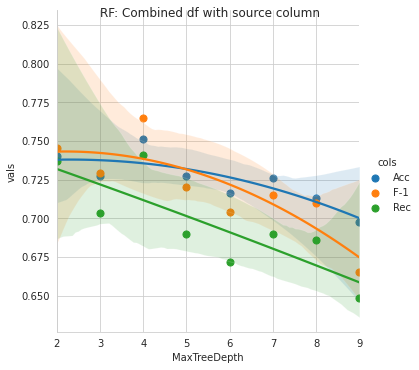

<Figure size 432x288 with 0 Axes>

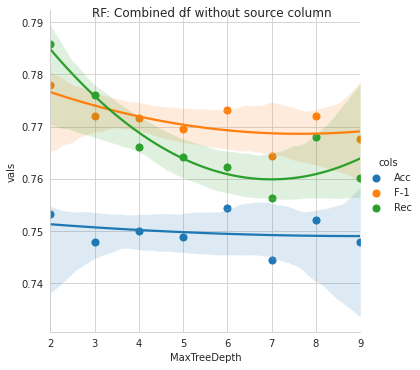

In [ ]:
# RF with source column
rf_combined_X = combined_df.drop('Target', axis=1)
results_df, best_FOR = RF(rf_combined_X, combined_df['Target'], combined_df, range(2, 10))

df_melt = results_df.melt('MaxTreeDepth', var_name='cols', value_name='vals')

plt.figure()
sns.lmplot(x='MaxTreeDepth', y='vals', data=df_melt, x_estimator=np.mean, order=2, hue='cols')
plt.gcf().suptitle("RF: Combined df with source column")

# RF without source column
rf_combined_no_source_X = combined_df.drop(['Target', "source"], axis=1)
results_df = RF(rf_combined_no_source_X, combined_df['Target'], combined_df, range(2, 10))[0]

df_melt = results_df.melt('MaxTreeDepth', var_name='cols', value_name='vals')

plt.figure()
sns.lmplot(x='MaxTreeDepth', y='vals', data=df_melt, x_estimator=np.mean, order=2, hue='cols')
plt.gcf().suptitle("RF: Combined df without source column")

The last method we try is xgBoost, but it turns out to not be any better than random forests.

In [ ]:
import xgboost as xgb


def XGB(X, Y, df, n_est):
    nSplits = 5
    results = []

    bestXGB = (None, 0)
    for n in n_est:
        kf = KFold(n_splits=nSplits, random_state=None, shuffle=False)
        acc_preds = []
        f1_preds = []
        rec_preds = []
      
        for train_index, test_index in kf.split(combined_df):
            xBoost = xgb.XGBClassifier(objective='binary:logistic', n_estimators=n, seed=123)
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

            #xBoost = RandomForestClassifier(max_depth=k, random_state=0)
            xBoost.fit(X_train, y_train)
            
            acc_preds.append(accuracy_score(y_test, xBoost.predict(X_test)))
            f1_preds.append(f1_score(y_test, xBoost.predict(X_test)))
            rec_preds.append(recall_score(y_test, xBoost.predict(X_test)))

        acc = np.sum(acc_preds)/nSplits
        f1 = np.sum(f1_preds)/nSplits
        rec = np.sum(rec_preds)/nSplits

        if acc > bestXGB[1]:
            bestXGB = (deepcopy(xBoost), acc)

        results.append({'n_estimators' : n,
                        'Acc': acc,
                        'F-1': f1,
                        'Rec': rec
                        })

    # results_df will be a data_frame in long format
    return pd.DataFrame(results), bestXGB[0]

Text(0.5, 0.98, 'XGB: Combined df with source column')

<Figure size 432x288 with 0 Axes>

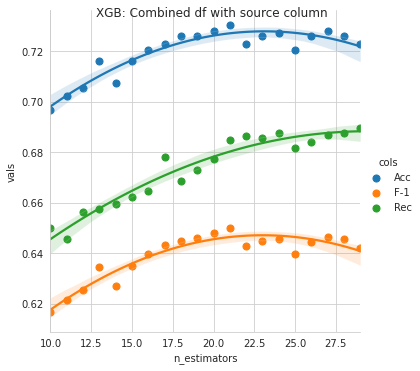

In [ ]:
# XGBBoost
xgb_X = combined_df.drop(['Target'], axis=1)
results_df, best_XGB = XGB(xgb_X, combined_df['Target'], combined_df, range(10,30))


df_melt = results_df.melt('n_estimators', var_name='cols', value_name='vals')

plt.figure()
sns.lmplot(x='n_estimators', y='vals', data=df_melt, x_estimator=np.mean, order=2, hue='cols')
plt.gcf().suptitle("XGB: Combined df with source column")

In [ ]:
from sklearn.naive_bayes import GaussianNB

def NB(X, Y, df):

    nSplits = 8
    results = []

    kf = StratifiedKFold(n_splits=nSplits, random_state=None, shuffle=False)
    
    acc_preds = []
    f1_preds = []
    rec_preds = []

    for train_index, test_index in kf.split(df, Y):
      
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        nb = GaussianNB()
        nb.fit(X_train, y_train)

        acc_preds.append(accuracy_score(y_test, nb.predict(X_test)))
        f1_preds.append(f1_score(y_test, nb.predict(X_test)))
        rec_preds.append(recall_score(y_test, nb.predict(X_test)))
      
    acc = np.sum(acc_preds)/nSplits
    f1 = np.sum(f1_preds)/nSplits
    rec = np.sum(rec_preds)/nSplits
    
    bestNB = deepcopy(nb)

    results.append({'Acc': acc,
                    'F-1': f1,
                    'Rec': rec
                    })

    # results_df will be a data_frame in long format
    return pd.DataFrame(results), bestNB
    

In [ ]:
# GaussianNB
nb_X = combined_df.drop(['Target'], axis=1)
res, best_NB = NB(xgb_X, combined_df['Target'], combined_df)
print(res['Acc'])
print(res['F-1'])
print(res['Rec'])

0    0.761957
Name: Acc, dtype: float64
0    0.768595
Name: F-1, dtype: float64
0    0.756913
Name: Rec, dtype: float64


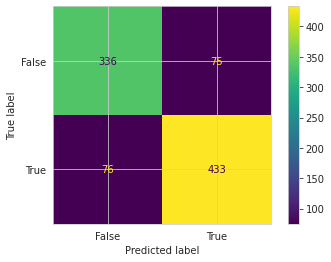

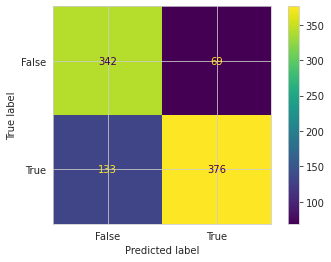

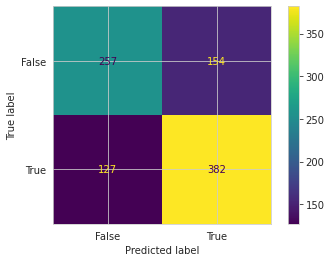

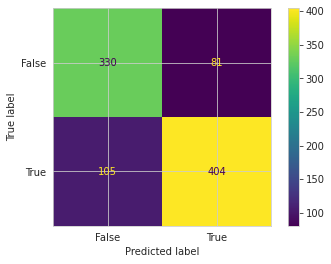

In [ ]:
X = combined_df.drop(['Target'], axis=1)
Y = combined_df['Target']

plot_confusion_matrix(best_FOR, X, Y, values_format='d')
plot_confusion_matrix(best_XGB, X, Y, values_format='d')
plot_confusion_matrix(best_KNN, X, Y, values_format='d')
plot_confusion_matrix(best_NB, X, Y, values_format='d')


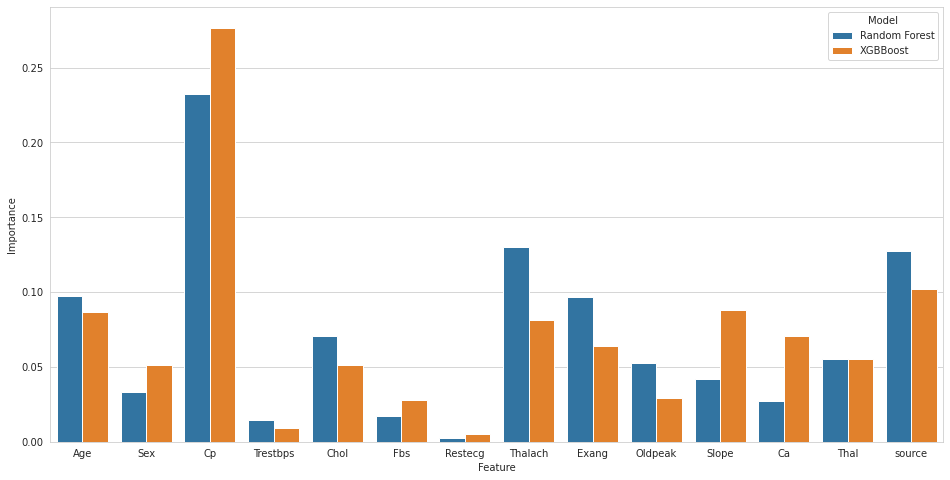

In [ ]:
forest_importance = list(best_FOR.feature_importances_)
xgb_importance = list(best_XGB.feature_importances_)

features = list(nb_X.columns)
rf_labels = ["Random Forest"]*len(forest_importance)
xgb_labels = ["XGBBoost"]*len(xgb_importance)


forest_df = pd.DataFrame(np.array([features, forest_importance, rf_labels]).T,
                         columns=["Feature", "Importance", "Model"])
xgb_df = pd.DataFrame(np.array([features, xgb_importance, xgb_labels]).T,
                      columns=["Feature", "Importance", "Model"])

combined_importance = pd.concat([forest_df, xgb_df])
combined_importance["Importance"] = pd.to_numeric(combined_importance["Importance"])

plt.figure(figsize=(16,8))
ax = sns.barplot(x="Feature", y="Importance", hue="Model", data=combined_importance)